<table width='100%'>
<tr>
<td style=''>
    <p align="left">
    Exercises for the course<br>
        <b>Deep Learning 1</b><br>
    Winter Semester 2022/25
    </p>
</td>
<td style=''>
    Machine Learning Group<br>
    <b>Faculty IV – Electrical Engineering and Computer Science</b><br>
    Technische Universität Berlin
</td>
</tr>
</table>

<br>
<center>
    <h1>Exercise Sheet 10 - Autoencoders</h1>
</center>
<br>

In this exercise, we would like to train an auto-encoder on the MNIST dataset.

We seek to optimize the objective:

\begin{align*}
\min_{\boldsymbol{\theta}} ~~
\underbrace{ \frac1N \sum_{i=1}^N \| \boldsymbol{x}_i - \hat{\boldsymbol{x}}_i \|^2}_{\text{reconstruction}}
\end{align*}

The reconstruction term is the standard mean square error between the data points and their reconstructions.

# Load MNIST dataset
First, we load the MNIST dataset and display some example images which show the general distribution of the data. The dataset is built into torchvision which automatically downloads the data into the `data` directory.

100%|██████████| 9.91M/9.91M [00:19<00:00, 499kB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 178kB/s]
100%|██████████| 1.65M/1.65M [00:02<00:00, 720kB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.57MB/s]


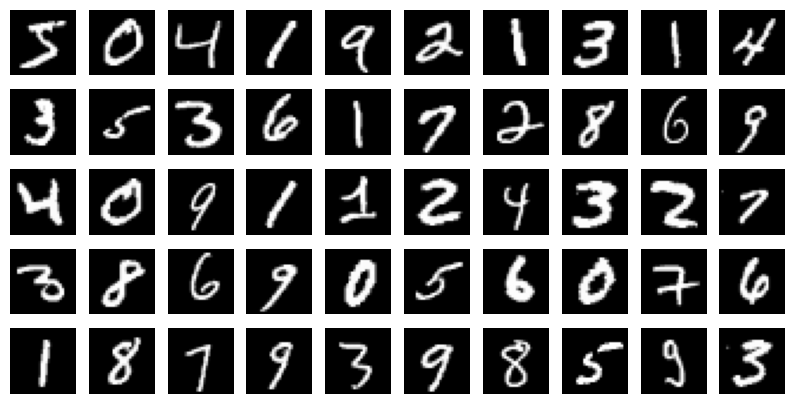

In [1]:
from torchvision.datasets import MNIST
from torchvision import transforms as T
import matplotlib.pyplot as plt
import torch

data_root = './data'
train_dataset = MNIST(data_root, train=True, download=True, transform=T.ToTensor())
test_dataset = MNIST(data_root, train=False, download=True, transform=T.ToTensor())

def show_samples(dataset):
    h, w = 5, 10
    fig, ax = plt.subplots(h, w)
    fig.set_size_inches((w, h))
    ax = ax.ravel()
    for i in range(h * w):
        img, _ = dataset[i]
        ax[i].imshow(torch.permute(img, (1, 2, 0)), cmap='gray')
        ax[i].axis('off')
    plt.show()

show_samples(train_dataset)

We can use a DataLoader together with the torchvision dataset which batches the data and can be used as an iterator.

In [2]:
from torch.utils.data import DataLoader
batch_size = 128

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# 1) Forward Pass (20P)

Please implement the forward pass of the network which receives a batch of image vectors $x \in \mathbb{R}^{N \times 1 \times 28 \times 28}$ and returns reconstructed images.

In [3]:
from torch import nn
import solution


class Autoencoder(nn.Module):

    def __init__(self, h: int = 32):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(784, 12000),
            nn.Dropout(0.2),
            nn.LeakyReLU(),
            nn.Linear(12000, h),
            nn.LeakyReLU(),
        )

        self.decoder = nn.Sequential(
            nn.Linear(h, 12000),
            nn.Dropout(0.2),
            nn.LeakyReLU(),
            nn.Linear(12000, 784),
            nn.Sigmoid(),
        )

    def forward(self, x: torch.Tensor):
        out = self.encoder(x)
        out = self.decoder(out)
        out = torch.reshape(out, (-1, 1, 28, 28))
        return out
        

# 2) Training Loop (20P)
The following method implements the training loop of the Autoencoder. Fill in the code for training a single iteration. The loss function to use should be clear from the lecture.

In [4]:
import torch
from torch import nn, optim
from tqdm.notebook import tqdm


def train(loader, h=32, epochs=5):
    model = Autoencoder(h)
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(epochs):
        print(f"Epoch {epoch+1:>2}")
        pbar = tqdm(loader)
        for batch, _ in pbar:
            optimizer.zero_grad()
            reconstruction = model(batch)
            loss = nn.functional.mse_loss(batch, reconstruction)
            loss.backward()
            optimizer.step()
            pbar.set_description(f"Loss: {loss.item():.4f}")

    return model

In [5]:
# Train the Autoencoder and receive respective parameters with hidden dimension 32
ae = train(train_loader, h=32, epochs=5)

Epoch  1


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch  2


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch  3


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch  4


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch  5


  0%|          | 0/469 [00:00<?, ?it/s]

# 3) Reconstruction (20P)
After the training, we want to see how good the model reconstructs the encoded example with the decoder.

Plot a few samples of the test set and next to them the reconstruction of the previously trained autoencoder

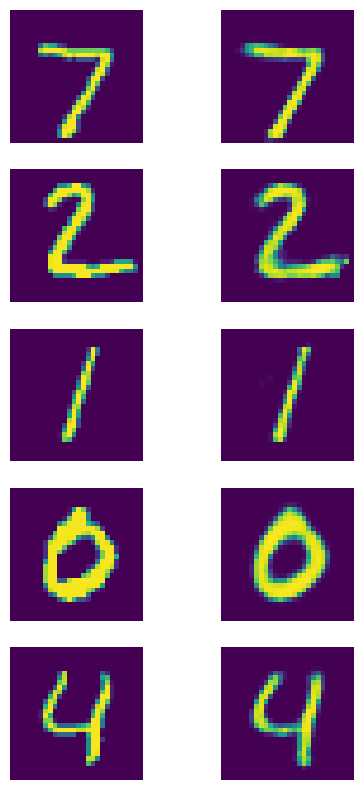

In [6]:
num_images = 5
test_batch = next(iter(test_loader))[0][:num_images]
reconstructions = ae(test_batch).squeeze().detach()
fig, ax = plt.subplots(num_images, 2)
fig.set_size_inches(5, 10 * (num_images // 5))
for i in range(num_images):
    ax[i][0].imshow(test_batch[i][0])
    ax[i][1].imshow(reconstructions[i])
    for a in ax[i]:
        a.axis("off")

We can see that we can still recover most of the digit details from the hidden representation.

# Anomaly Detection
Now we want to use an Autoencoder for anomaly detection. Given a set of normal data points, anomaly detection wants to assign a high anomaly score for samples that are in some way abnormal from the set of normal samples. In our example the normal samples will be all digits up until `threshold_class` (exclusive). All other samples are considered anomalies. You may play around with this parameter, for now we will fix it to 1, meaning we will only consider 0's.

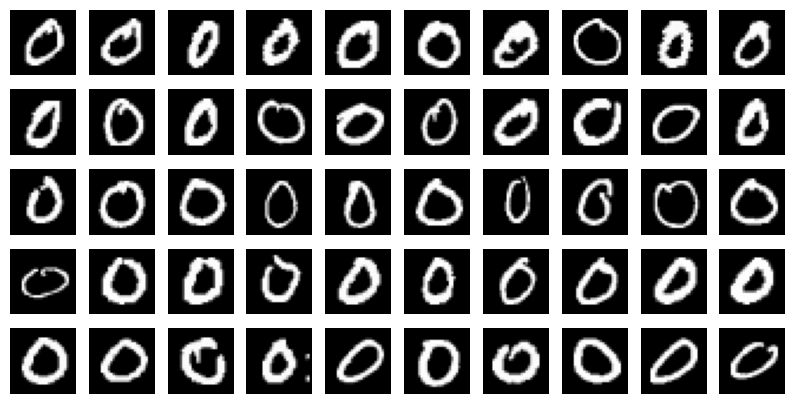

In [7]:
import copy
from torch.utils.data import Subset
import numpy as np

threshold_class = 1
threshold_class_train = Subset(dataset=copy.deepcopy(train_dataset), indices=np.where(train_dataset.targets < threshold_class)[0])
train_threshold_class_loader = DataLoader(threshold_class_train, batch_size=64, shuffle=True)
show_samples(threshold_class_train)

In [8]:
# We increase number of epochs because the dataset is now smaller.
anomaly_ae = train(train_threshold_class_loader, h=32, epochs=10)

Epoch  1


  0%|          | 0/93 [00:00<?, ?it/s]

Epoch  2


  0%|          | 0/93 [00:00<?, ?it/s]

Epoch  3


  0%|          | 0/93 [00:00<?, ?it/s]

Epoch  4


  0%|          | 0/93 [00:00<?, ?it/s]

Epoch  5


  0%|          | 0/93 [00:00<?, ?it/s]

Epoch  6


  0%|          | 0/93 [00:00<?, ?it/s]

Epoch  7


  0%|          | 0/93 [00:00<?, ?it/s]

Epoch  8


  0%|          | 0/93 [00:00<?, ?it/s]

Epoch  9


  0%|          | 0/93 [00:00<?, ?it/s]

Epoch 10


  0%|          | 0/93 [00:00<?, ?it/s]

# 4) Anomaly Score (20P)
Given now the trained autoencoder, we want to assign each sample an anomaly score. By using your knowledge from the lecture, implement the anomaly score for a batch of samples x, given its reconstruction from the autoencoder. The function should return an array that holds an anomaly score for each sample of the batch.

In [9]:
import solution

def anomaly_score(x, reconstruction):
    return nn.functional.mse_loss(x, reconstruction, reduction="none").mean(
        dim=(1, 2, 3)
    )

### Evaluating 
For all the samples from the test set, we compute the anomaly score. Then, we want to check how good the anomaly score seperates the normal samples from the anomalies. For that purpose, the `roc_auc_score` can be used. A larger score indicates that the normal samples can be better seperated from the anomalies. We also plot a histogram with the anomaly scores to visualize the separation.

AUC: 0.9947799674193402


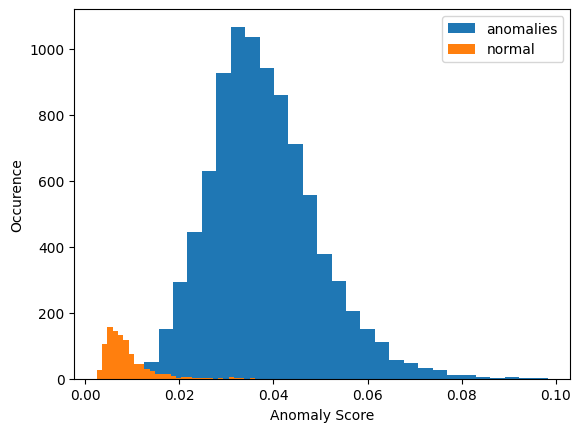

In [11]:
from sklearn.metrics import roc_auc_score

def compute_anomaly_scores(test_loader, ae):
    anomaly_scores = []
    labels = []
    for x, y in test_loader:
        reconstruction = ae(x).detach()
        batch_anomaly_scores = anomaly_score(x, reconstruction)
        # label 0 if sample is normal, otherwise 1
        batch_labels = (y >= threshold_class).numpy()
        anomaly_scores.append(batch_anomaly_scores)
        labels.append(batch_labels)
    anomaly_scores = np.concatenate(anomaly_scores)
    labels = np.concatenate(labels)
    return anomaly_scores, labels

test_loader = DataLoader(test_dataset, batch_size=64)
anomaly_scores, labels = compute_anomaly_scores(test_loader, anomaly_ae)
score = roc_auc_score(labels, anomaly_scores)

print('AUC:', score)
for name, label in [('anomalies', 1), ('normal', 0)]:
    plt.hist(anomaly_scores[labels == label], bins=30, label=name)
plt.ylabel('Occurence')
plt.xlabel('Anomaly Score')
plt.legend()
plt.show()

We can see that the zero digit (normal data) and all other digits are well separated with the anomaly score.

## Anomaly Heatmaps
One advantage of the autoencoder anomaly detection method is that we can use the reconstructions as an anomaly heatmap. These show which parts could not be reconstructed well from the model. The code below plots for selected samples the reconstruction and the anomaly heatmap.

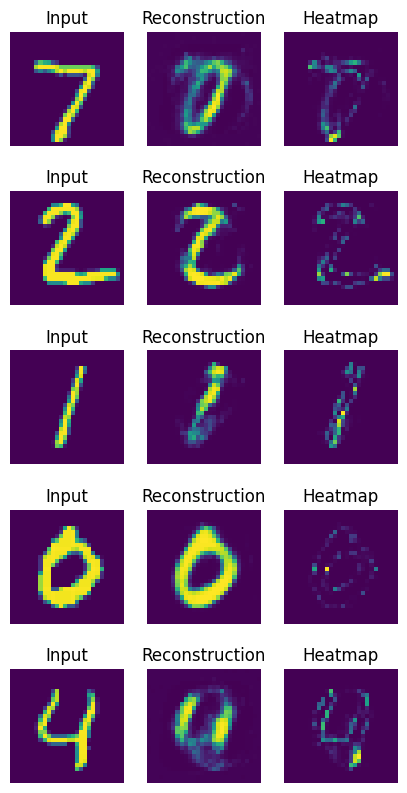

In [12]:
num_images = 5
test_batch = next(iter(test_loader))[0][:num_images]
reconstructions = anomaly_ae(test_batch).squeeze().detach()

fig, ax = plt.subplots(num_images, 3)
fig.set_size_inches(5, 10)
for i in range(num_images):
    ax[i][0].imshow(test_batch[i][0])
    ax[i][0].set_title('Input')
    ax[i][1].imshow((reconstructions[i]))
    ax[i][1].set_title('Reconstruction')
    ax[i][2].imshow((reconstructions[i] - test_batch[i][0])**2)
    ax[i][2].set_title('Heatmap')
    for a in ax[i]:
        a.axis('off')

# Latent Space Visualization

Another interesting thing is the latent space of the autoencoder. Here we will visualize it by training a new autoencoder with a hidden dimension of 2, so that we can plot the latent representations of images using matplotlib.

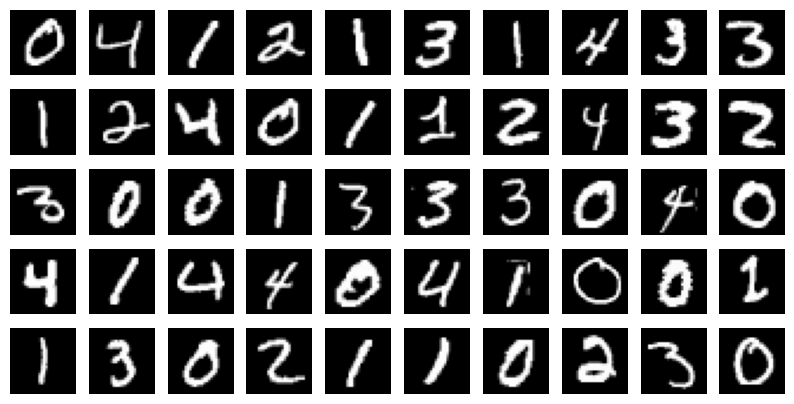

Epoch  1


  0%|          | 0/479 [00:00<?, ?it/s]

Epoch  2


  0%|          | 0/479 [00:00<?, ?it/s]

Epoch  3


  0%|          | 0/479 [00:00<?, ?it/s]

Epoch  4


  0%|          | 0/479 [00:00<?, ?it/s]

Epoch  5


  0%|          | 0/479 [00:00<?, ?it/s]

In [13]:
threshold_class = 5
threshold_class_train = Subset(dataset=copy.deepcopy(train_dataset), indices=np.where(train_dataset.targets < threshold_class)[0])
train_threshold_class_loader = DataLoader(threshold_class_train, batch_size=64, shuffle=True)
show_samples(threshold_class_train)

small_ae = train(train_threshold_class_loader, h=2, epochs=5)

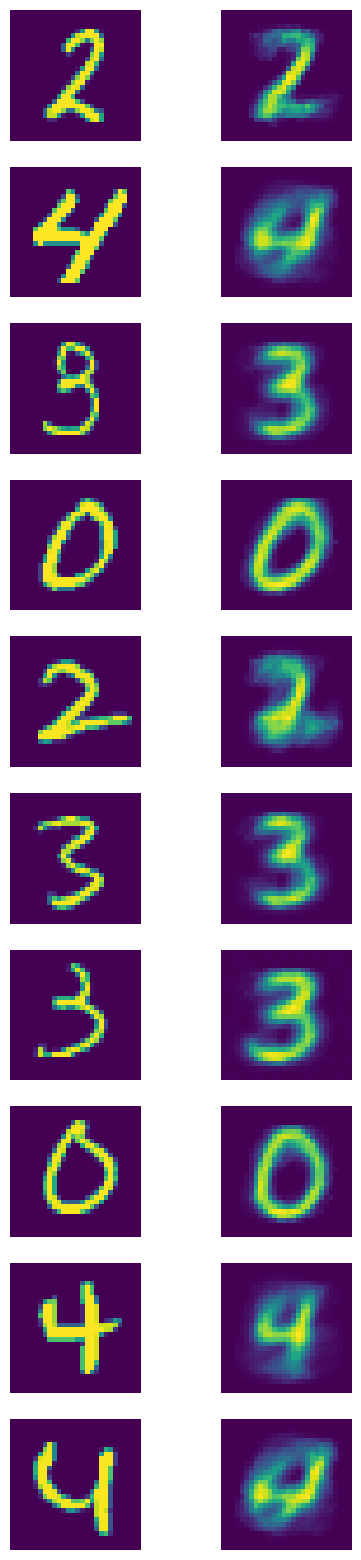

In [14]:
num_images = 10
test_batch = next(iter(train_threshold_class_loader))[0][:num_images]
reconstructions = small_ae(test_batch).squeeze().detach()
fig, ax = plt.subplots(num_images, 2)
fig.set_size_inches(5, 10 * (num_images // 5))
for i in range(num_images):
    ax[i][0].imshow(test_batch[i][0])
    ax[i][1].imshow(reconstructions[i])
    for a in ax[i]:
        a.axis("off")

# 5) Latent scatter plot (20P)

In this task you should plot the latent representations. You can use the labels as color information using `plt.scatter(c=labels)`.

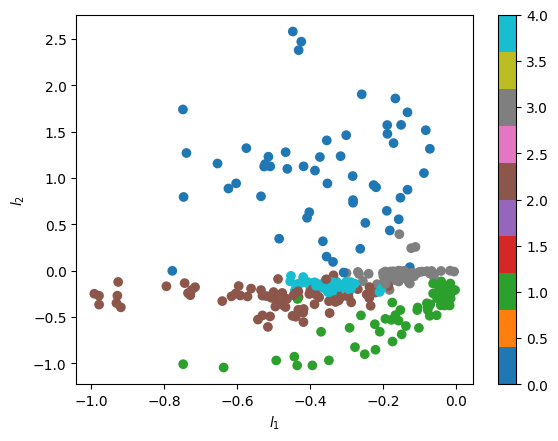

In [18]:
images, labels = [], []

for i, (x, y) in enumerate(train_threshold_class_loader):
    images.append(x)
    labels.append(y)
    if i > 3:
        break

images = torch.cat(images)
labels = torch.cat(labels)

latents = small_ae.encoder(images)

plt.scatter(*latents.T.detach(), c=labels, cmap="tab10")
plt.xlabel("$l_1$")
plt.ylabel("$l_2$")
plt.colorbar()
plt.show()
